In [1]:
# https://quinlangroup.slack.com/archives/C02KEHXJ274/p1724332317643529
# /scratch/ucgd/lustre-labs/quinlan/u6018199/cyvcf2
# https://quinlangroup.slack.com/archives/C449KJT3J/p1751389842484399
from cyvcf2 import VCF  # type: ignore

from tqdm import tqdm 
import numpy as np

import polars as pl
import importlib

SAMPLE = '200081' 
NUMBER_VARIANTS = 100000 # TODO: testing
PB_CPG_TOOL_MODE = 'model'

pl.Config.set_tbl_rows(25)

from pathlib import Path

READ_BACKED_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/read-backed-phasing')
HAPLOTYPE_MAPS_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/haplotype-maps/CEPH1463.GRCh38')
METH_READ_BACKED_PHASED_DIR = Path(f'/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.{PB_CPG_TOOL_MODE}.read-backed-phased')
METH_FOUNDER_PHASED_DIR = Path(f'/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.{PB_CPG_TOOL_MODE}.founder-phased') 

CPG_SITE_MISMATCH_SITE_DISTANCE = 50 # bp

REFERENCE_GENOME = "hg38"

import sys

REPO_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/u6018199/dna-methylation')
sys.path.append(str(REPO_DIR / 'util')) # hover over, e.g., "from shell import shell", etc., below, and choose "quick fix" to make pylance aware of this path

### Phase alleles at SNPs to read-backed haplotypes and founder haplotypes 

In [2]:
def stringify(phase_block_id): 
    if phase_block_id == -2147483648: # https://github.com/brentp/cyvcf2/issues/31#issuecomment-273214346
        return '.'
    else: 
        return str(phase_block_id)

def is_snv_het(variant, sample_index):
    # gt_types is array of 0,1,2,3==HOM_REF, HET, UNKNOWN, HOM_ALT
    # https://brentp.github.io/cyvcf2/#cyvcf2
    gt_types = variant.gt_types
    is_het = gt_types[sample_index] == 1 # 1 indicates heterozygous

    # Even without filtering to hets, all sites in bit-vectors in first 40mb of chr1 are observed to be hets.
    # Therefore constructing bitvectors from hets only is not actually restrictive, AND allows us to track only 2 bitvectors, instead of 4.

    is_snp = variant.is_snp

    # is_snp allows multiallelic sites, so multiplicity of ALT alleles must be tested separately 
    # https://github.com/brentp/cyvcf2/blob/541ab16a255a5287c331843d8180ed6b9ef10e00/cyvcf2/cyvcf2.pyx#L1903-L1911
    has_single_ALT_allele = len(variant.ALT) == 1

    return is_het and is_snp and has_single_ALT_allele

def get_read_based_phasing(uid):
    # allele format: hap1 | hap2 
    vcf_file_path = READ_BACKED_PHASED_DIR / f"{uid}.GRCh38.deepvariant.glnexus.phased.vcf.gz"

    records = []
    with VCF(vcf_file_path, strict_gt=True) as vcf_reader: # cyvcf2 handles .vcf.gz directly
        # # assume multi-sample vcf:
        # samples = vcf_reader.samples
        # sample_index = samples.index(uid) if uid in samples else None

        # assume single-sample vcf: 
        samples = vcf_reader.samples
        assert len(samples) == 1, f"Expected single sample in VCF, found {len(samples)} samples: {samples}"
        sample_index = 0

        # for variant in tqdm(vcf_reader, total=vcf_reader.num_records): # TODO 
        for i, variant in enumerate(vcf_reader): # TODO: testing
            if i >= NUMBER_VARIANTS: # TODO: testing
                break

            if not is_snv_het(variant, sample_index):
                continue
        
            chrom = variant.CHROM
            pos = variant.POS # pos is 1-based
            start = pos - 1 
            end = pos 
            REF = variant.REF
            ALT = variant.ALT[0]  

            phase_block_id_all_samples = variant.format('PS')
            if phase_block_id_all_samples is None:   
                phase_block_id = '.' 
            else:
                phase_block_id = phase_block_id_all_samples[sample_index, 0] 
                phase_block_id = stringify(phase_block_id)

            # single sample of 0|1 in vcf becomes [[0, 1, True]]
            # 2 samples of 0/0 and 1|1 would be [[0, 0, False], [1, 1, True]]
            # https://brentp.github.io/cyvcf2/#cyvcf2
            genotype_all_samples = variant.genotypes
            genotype = genotype_all_samples[sample_index]

            # "-1" in "genotype" indicates missing data: 
            # c.f., "test_set_gts" at: https://github.com/brentp/cyvcf2/issues/31#issuecomment-275195917
            # hap1 | hap2 
            #   https://github.com/PacificBiosciences/HiPhase/blob/main/docs/user_guide.md#haplotagged-bam-files
            #   https://whatshap.readthedocs.io/en/latest/guide.html#whatshap-haplotag-algorithm
            allele_hap1 = str(genotype[0]) if genotype[0] != -1 else '.'
            allele_hap2 = str(genotype[1]) if genotype[1] != -1 else '.'

            phased = genotype[2]
            if not phased: 
                continue 

            records.append({ 
                "chrom": chrom,
                "start": start,
                "end": end,
                "REF": REF,
                "ALT": ALT,
                "phase_block_id": phase_block_id,
                "allele_hap1": allele_hap1,
                "allele_hap2": allele_hap2,
            })

    df = pl.DataFrame(records)
    return df 

get_read_based_phasing(uid=SAMPLE) 

chrom,start,end,REF,ALT,phase_block_id,allele_hap1,allele_hap2
str,i64,i64,str,str,str,str,str
"""chr1""",11862,11863,"""C""","""A""","""11863""","""0""","""1"""
"""chr1""",11921,11922,"""T""","""A""","""11863""","""0""","""1"""
"""chr1""",15117,15118,"""A""","""G""","""11863""","""0""","""1"""
"""chr1""",15819,15820,"""G""","""T""","""11863""","""1""","""0"""
"""chr1""",16013,16014,"""C""","""T""","""11863""","""0""","""1"""
"""chr1""",16948,16949,"""A""","""C""","""11863""","""0""","""1"""
"""chr1""",17019,17020,"""G""","""A""","""11863""","""0""","""1"""
"""chr1""",17384,17385,"""G""","""A""","""11863""","""0""","""1"""
"""chr1""",18088,18089,"""G""","""T""","""11863""","""0""","""1"""


In [3]:
def get_phase_blocks(uid): 
    df = (
        pl
        .read_csv(
            READ_BACKED_PHASED_DIR / f"{uid}.GRCh38.hiphase.blocks.tsv",
            separator="\t",
            has_header=True,
            infer_schema_length=1000000,
            # n_rows=100000  # TODO: testing
        )
        .cast({
            "phase_block_id": pl.String,
        })
    )
    return df

get_phase_blocks(uid=SAMPLE)

source_block_index,sample_name,phase_block_id,chrom,start,end,num_variants
i64,i64,str,str,i64,i64,i64
0,200081,"""11863""","""chr1""",11863,204487,479
1,200081,"""257716""","""chr1""",257716,292262,110
2,200081,"""350805""","""chr1""",350805,396627,205
4,200081,"""416412""","""chr1""",416412,433777,76
6,200081,"""492339""","""chr1""",492339,532812,56
8,200081,"""593123""","""chr1""",593123,1314109,1169
9,200081,"""1351126""","""chr1""",1351126,1382658,5
10,200081,"""1421668""","""chr1""",1421668,1427528,2
11,200081,"""1432961""","""chr1""",1432961,2931691,2168


In [4]:
import write_data
importlib.reload(write_data)
from write_data import write_bed
from shell import shell

# For visualization in IGV 
def write_phase_blocks(uid): 
    df_phase_blocks = get_phase_blocks(uid)
    df_phase_blocks = df_phase_blocks.select([
        pl.col("chrom"),
        pl.col("start"),
        pl.col("end"),
    ])
    write_bed(METH_FOUNDER_PHASED_DIR, df_phase_blocks, f"{uid}.phase-blocks")

    cmd = (
        f'cat {METH_FOUNDER_PHASED_DIR}/{uid}.phase-blocks.bed'
        f' | util/sort-compress-index-bed'
        f' --name {METH_FOUNDER_PHASED_DIR}/{uid}.phase-blocks'
    )
    shell(cmd) 
    shell(f'rm {METH_FOUNDER_PHASED_DIR}/{uid}.phase-blocks.bed')

# write_phase_blocks(SAMPLE) 

In [5]:
def get_parental_phasing(uid): 
    # "paternal | maternal" 
    # https://quinlangroup.slack.com/archives/C08U7NLC9PZ/p1748885496941579
    vcf_file_path = HAPLOTYPE_MAPS_DIR / "CEPH1463.GRCh38.pass.sorted.vcf"

    records = []
    with VCF(vcf_file_path, strict_gt=True) as vcf_reader: # cyvcf2 handles .vcf.gz directly
        samples = vcf_reader.samples
        sample_index = samples.index(uid) if uid in samples else None

        # for variant in tqdm(vcf_reader, total=vcf_reader.num_records): # TODO 
        for i, variant in enumerate(vcf_reader): # TODO: testing
            if i >= NUMBER_VARIANTS: # TODO: testing
                break

            if not is_snv_het(variant, sample_index):
                continue

            chrom = variant.CHROM
            pos = variant.POS # pos is 1-based
            start = pos - 1 
            end = pos
            REF = variant.REF
            ALT = variant.ALT[0]

            # single sample of 0|1 in vcf becomes [[0, 1, True]]
            # 2 samples of 0/0 and 1|1 would be [[0, 0, False], [1, 1, True]]
            # https://brentp.github.io/cyvcf2/#cyvcf2
            genotype_all_samples = variant.genotypes
            genotype = genotype_all_samples[sample_index]

            # "-1" in "genotype" indicates missing data: 
            # c.f., "test_set_gts" at: https://github.com/brentp/cyvcf2/issues/31#issuecomment-275195917
            allele_pat = str(genotype[0]) if genotype[0] != -1 else '.'
            allele_mat = str(genotype[1]) if genotype[1] != -1 else '.'

            phased = genotype[2]

            if not phased: 
                raise ValueError(f"Expected phased genotype, but found unphased: {genotype}")

            records.append({ 
                "chrom": chrom,
                "start": start,
                "end": end,
                "REF": REF,
                "ALT": ALT,
                "allele_pat": allele_pat,
                "allele_mat": allele_mat,
            })
 
    df = pl.DataFrame(records)
    return df 

get_parental_phasing(uid=SAMPLE)

chrom,start,end,REF,ALT,allele_pat,allele_mat
str,i64,i64,str,str,str,str
"""chr1""",497702,497703,"""T""","""C""","""1""","""0"""
"""chr1""",500803,500804,"""T""","""C""","""1""","""0"""
"""chr1""",502903,502904,"""T""","""C""","""1""","""0"""
"""chr1""",504316,504317,"""T""","""C""","""0""","""1"""
"""chr1""",505781,505782,"""C""","""T""","""0""","""1"""
"""chr1""",506629,506630,"""A""","""G""","""1""","""0"""
"""chr1""",512114,512115,"""A""","""G""","""0""","""1"""
"""chr1""",514052,514053,"""A""","""G""","""1""","""0"""
"""chr1""",515920,515921,"""C""","""T""","""1""","""0"""


In [6]:
import bioframe as bf # https://bioframe.readthedocs.io/en/latest/index.html

def get_founder_phasing(uid):
    founder_label_file_path = HAPLOTYPE_MAPS_DIR / "CEPH1463.GRCh38.iht.sorted.txt"

    records = []
    with open(founder_label_file_path, 'r') as f:
        header = f.readline().strip().strip('#')
        assert header.startswith("chrom start end"), f"Unexpected header format: {header}"
        assert header.endswith("marker_count len markers"), f"Unexpected header format: {header}"
        samples = header.split()[3:-3]  # skip first 3 columns (chrom, start, end) and last 3 columns (marker_count len markers)
        sample_index = samples.index(uid) if uid in samples else None

        for line in f:
            line = line.strip()
            fields = line.split()

            chrom, start, end = fields[:3] 

            genotypes_all_samples = fields[3:-3] # skip first 3 columns (chrom, start, end) and last 3 columns (marker_count len markers)
            genotype = genotypes_all_samples[sample_index] # type: ignore
            if '/' in genotype:
                raise ValueError(f"This sample is a founder and therefore cannot be inheritance-based phased")
            founder_label_pat, founder_label_mat = genotype.split('|')

            if founder_label_pat == '?' and founder_label_mat == '?':
                continue

            records.append({
                "chrom": chrom,
                "start": int(start),
                "end": int(end),
                "founder_label_pat": founder_label_pat,
                "founder_label_mat": founder_label_mat,
            })
            
    df = pl.DataFrame(records)
    return df 

get_founder_phasing(uid=SAMPLE)

chrom,start,end,founder_label_pat,founder_label_mat
str,i64,i64,str,str
"""chr1""",13301,1610923,"""B""","""I"""
"""chr1""",1613420,3184712,"""B""","""I"""
"""chr1""",3184788,3200879,"""B""","""I"""
"""chr1""",3203589,3398794,"""B""","""I"""
"""chr1""",3399126,5038259,"""B""","""I"""
"""chr1""",5038659,5097605,"""B""","""I"""
"""chr1""",5097819,6082247,"""B""","""I"""
"""chr1""",6082326,9098705,"""B""","""I"""
"""chr1""",9098937,9424618,"""B""","""I"""


In [7]:
# For visualization in IGV 
def write_iht_blocks(uid): 
    df_iht_blocks = get_founder_phasing(uid)
    df_iht_blocks = df_iht_blocks.select([
        pl.col("chrom"),
        pl.col("start"),
        pl.col("end"),
    ])
    write_bed(METH_FOUNDER_PHASED_DIR, df_iht_blocks, f"{uid}.iht-blocks")

    cmd = (
        f'cat {METH_FOUNDER_PHASED_DIR}/{uid}.iht-blocks.bed'
        f' | util/sort-compress-index-bed'
        f' --name {METH_FOUNDER_PHASED_DIR}/{uid}.iht-blocks'
    )
    shell(cmd) 
    shell(f'rm {METH_FOUNDER_PHASED_DIR}/{uid}.iht-blocks.bed')

# write_iht_blocks(SAMPLE) 

In [8]:
def get_all_phasing(uid):
    df_read_based_phasing = get_read_based_phasing(uid)
    df_phase_blocks = get_phase_blocks(uid)
    df = (
        df_read_based_phasing
        .join(
            df_phase_blocks,
            on=["chrom", "phase_block_id"], 
            how="inner"
        )
        .rename({
            "start_right": "start_phase_block",
            "end_right": "end_phase_block",
            "num_variants": "num_variants_phase_block",
        })
        .join(
            get_parental_phasing(uid), 
            # Join on REF and ALT, in addition to joining on chrom, start, end
            # This is important because the parental-phased vcf results from joint-calling, 
            # whereas the read-backed-phased vcf results from single-sample calling,
            # so REF and ALT may differ between the two data sources 
            on=["chrom", "start", "end", "REF", "ALT"], 
            how="inner"
        )
    )

    df = bf.overlap(
        df.to_pandas(), 
        get_founder_phasing(uid).to_pandas(), 
        how='inner', 
        suffixes=('','_iht_block'),
        cols2=["chrom", "start", "end"]
    ).drop([
        "source_block_index", 
        "sample_name", 
        "phase_block_id", 
        "num_variants_phase_block", 
        "chrom_iht_block"
    ], axis=1)  
    
    df = pl.from_pandas(df)
    df = df.sort(["chrom", "start", "end"])

    return df

# Note: there are no bit vectors prior to 500kb: 
# https://quinlangroup.slack.com/archives/C09027S4C5Q/p1750792033498849
get_all_phasing(uid=SAMPLE)

# pl.DataFrame(bf.select(
#     df=get_all_phasing(uid=SAMPLE).to_pandas(),
#     region="chr1:500,000-1,500,000",
#     cols=["chrom", "start", "end"]
# ))

chrom,start,end,REF,ALT,allele_hap1,allele_hap2,start_phase_block,end_phase_block,allele_pat,allele_mat,start_iht_block,end_iht_block,founder_label_pat_iht_block,founder_label_mat_iht_block
str,i64,i64,str,str,str,str,i64,i64,str,str,i64,i64,str,str
"""chr1""",497702,497703,"""T""","""C""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""
"""chr1""",500803,500804,"""T""","""C""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""
"""chr1""",502903,502904,"""T""","""C""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""
"""chr1""",504316,504317,"""T""","""C""","""1""","""0""",492339,532812,"""0""","""1""",13301,1610923,"""B""","""I"""
"""chr1""",505781,505782,"""C""","""T""","""1""","""0""",492339,532812,"""0""","""1""",13301,1610923,"""B""","""I"""
"""chr1""",506629,506630,"""A""","""G""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""
"""chr1""",512114,512115,"""A""","""G""","""1""","""0""",492339,532812,"""0""","""1""",13301,1610923,"""B""","""I"""
"""chr1""",514052,514053,"""A""","""G""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""
"""chr1""",515920,515921,"""C""","""T""","""0""","""1""",492339,532812,"""1""","""0""",13301,1610923,"""B""","""I"""


### Construct a Hap Map, consisting of intervals in which read-backed haplotypes are mapped to founder haplotypes

In [22]:
def extract_bit_vector(l): 
    return np.array([int(x) for x in l[0]], dtype=np.uint8)

def extract_bit_vectors(record):
    bit_vector_hap1 = extract_bit_vector(record["allele_seq_hap1"])
    bit_vector_pat = extract_bit_vector(record["allele_seq_pat"])
    return bit_vector_hap1, bit_vector_pat

def write_df_to_vcf(df, path, uid):
    df = df.sort(["chrom", "start", "end"]) 

    header = [
        '##fileformat=VCFv4.2',
        '#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t' + uid
    ]
    
    with open(path, 'w') as f:
        for line in header:
            f.write(line + '\n')
        
        for row in df.iter_rows(named=True):
            chrom = row['chrom']
            pos = row['start'] + 1  # VCF is 1-based
            id_ = '.'
            ref = row['REF']
            alt = row['ALT']
            qual = '.'
            flt = '.'
            info = '.'
            fmt_keys = '.'
            fmt_vals = '.'
            f.write(f"{chrom}\t{pos}\t{id_}\t{ref}\t{alt}\t{qual}\t{flt}\t{info}\t{fmt_keys}\t{fmt_vals}\n")

# For visualization in IGV 
def write_bit_vector_sites_and_mismatches(df_sites, df_sites_mismatch, uid):
    dfs = {
        # "sites": df_sites,
        "sites-mismatches": df_sites_mismatch,
    }
    for name, df in dfs.items():
        write_df_to_vcf(df, f"{METH_FOUNDER_PHASED_DIR}/{uid}.bit-vector-{name}.vcf", uid)

        cmd = (
            f'util/compress-index-vcf'
            f' --name {METH_FOUNDER_PHASED_DIR}/{uid}.bit-vector-{name}'
        )
        shell(cmd) 

# For visualization in IGV 
def write_hap_map_blocks(df_hap_map, uid, parental): 
    df_hap_map_blocks = df_hap_map.select([
        pl.col("chrom"),
        pl.col("start"),
        pl.col("end"),
        # pl.col(f"{parental}_haplotype").str.split("_").list.get(0).alias(f"founder_haplotype_{parental}")
        pl.col(f"{parental}_haplotype")
    ])
    write_bed(METH_FOUNDER_PHASED_DIR, df_hap_map_blocks, f"{uid}.hap-map-blocks.{parental}")

    cmd = (
        f'cat {METH_FOUNDER_PHASED_DIR}/{uid}.hap-map-blocks.{parental}.bed'
        f' | util/sort-compress-index-bed'
        f' --name {METH_FOUNDER_PHASED_DIR}/{uid}.hap-map-blocks.{parental}'
    )
    shell(cmd) 
    shell(f'rm {METH_FOUNDER_PHASED_DIR}/{uid}.hap-map-blocks.{parental}.bed')

def get_hap_map(uid):
    df_all_phasing = get_all_phasing(uid)

    df_sites = df_all_phasing.select(["chrom", "start", "end", "REF", "ALT"])

    # Group het SNVs by (chrom, phase_block, iht_block), 
    # which implicitly finds the intersection of these two types of blocks, 
    # and compute the read-backed and inheritance-backed bit vectors in those intersections
    df_grouped = (
        df_all_phasing
        .group_by([
            "chrom", 
            "start_phase_block", "end_phase_block", 
            "start_iht_block", "end_iht_block", 
            "founder_label_pat_iht_block", "founder_label_mat_iht_block"
        ])
        .agg([
            pl.col("start").implode().alias("start_seq"),
            pl.col("end").implode().alias("end_seq"),
            pl.col("allele_hap1").implode().alias("allele_seq_hap1"),
            pl.col("allele_pat").implode().alias("allele_seq_pat"),
            pl.col("REF").implode().alias("REF_seq"),
            pl.col("ALT").implode().alias("ALT_seq"),
        ])
        .sort("start_phase_block")  # Sort by phase_block_id for reproducibility 
    )

    records_hap_map = []
    data_mismatch = []
    for record_hap_map in df_grouped.iter_rows(named=True):
        (
            bit_vector_hap1, 
            bit_vector_pat, 
        ) = extract_bit_vectors(record_hap_map)

        record_hap_map["num_het_SNVs"] = len(bit_vector_hap1)

        starts = np.array(record_hap_map["start_seq"][0])
        ends = np.array(record_hap_map["end_seq"][0])
        REFs = np.array(record_hap_map["REF_seq"][0])
        ALTs = np.array(record_hap_map["ALT_seq"][0])

        hap1_pat_mismatch = bit_vector_hap1 != bit_vector_pat 
        edit_distance_hap1_pat = np.sum(hap1_pat_mismatch)
        similarity_hap1_pat = 1 - (edit_distance_hap1_pat/len(bit_vector_hap1)) 

        if (similarity_hap1_pat > 0.5): # similarity_hap1_pat + similarity_hap1_mat = 1.0 (SNVs are hets)
            record_hap_map["paternal_haplotype"] = record_hap_map["founder_label_pat_iht_block"] + "_hap1"
            record_hap_map["maternal_haplotype"] = record_hap_map["founder_label_mat_iht_block"] + "_hap2"
            record_hap_map["haplotype_concordance"] = similarity_hap1_pat

            starts_mismatch = starts[hap1_pat_mismatch]
            ends_mismatch = ends[hap1_pat_mismatch]
            REFs_mismatch = REFs[hap1_pat_mismatch]
            ALTs_mismatch = ALTs[hap1_pat_mismatch]
        else: 
            record_hap_map["maternal_haplotype"] = record_hap_map["founder_label_mat_iht_block"] + "_hap1"
            record_hap_map["paternal_haplotype"] = record_hap_map["founder_label_pat_iht_block"] + "_hap2"
            record_hap_map["haplotype_concordance"] = 1.0 - similarity_hap1_pat

            starts_mismatch = starts[~hap1_pat_mismatch] 
            ends_mismatch = ends[~hap1_pat_mismatch]
            REFs_mismatch = REFs[~hap1_pat_mismatch]
            ALTs_mismatch = ALTs[~hap1_pat_mismatch]

        records_hap_map.append(record_hap_map)

        data_mismatch.append({
            "chrom": record_hap_map["chrom"],
            "start": starts_mismatch,
            "end": ends_mismatch,
            "REF": REFs_mismatch,
            "ALT": ALTs_mismatch
        })

    df_hap_map = (
        pl
        .DataFrame(records_hap_map)
        .drop([
            "allele_seq_hap1", 
            "allele_seq_pat", 
            "founder_label_pat_iht_block",
            "founder_label_mat_iht_block",
        ])
        .with_columns(
            pl.max_horizontal("start_phase_block", "start_iht_block").alias("start"), # start of intersection
            pl.min_horizontal("end_phase_block", "end_iht_block").alias("end"), # end of intersection
        )
        .select([
            "chrom", "start", "end", 
            "paternal_haplotype", "maternal_haplotype", 
            "haplotype_concordance", "num_het_SNVs",
        ])
        .sort(["chrom", "start", "end"])
    )

    write_hap_map_blocks(df_hap_map, uid, "paternal")
    write_hap_map_blocks(df_hap_map, uid, "maternal")
    write_bed(METH_FOUNDER_PHASED_DIR, df_hap_map, f"{uid}.hap-map-blocks")

    schema = {"chrom": pl.String, "start": pl.Int64, "end": pl.Int64, "REF": pl.String, "ALT": pl.String}
    df_sites_mismatch = pl.concat([pl.DataFrame(dm, schema=schema) for dm in data_mismatch])

    write_bit_vector_sites_and_mismatches(df_sites, df_sites_mismatch, uid)

    return df_hap_map, df_sites_mismatch

DF_HAP_MAP, DF_SITES_MISMATCH = get_hap_map(uid=SAMPLE)
DF_HAP_MAP

+ sort --parallel=8 --buffer-size=75% --version-sort -k1,1 -k2,2 /dev/stdin
+ bgzip --force --stdout
+ tabix --force --preset bed /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.model.founder-phased/200081.hap-map-blocks.paternal.sorted.bed.gz

+ sort --parallel=8 --buffer-size=75% --version-sort -k1,1 -k2,2 /dev/stdin
+ bgzip --force --stdout
+ tabix --force --preset bed /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.model.founder-phased/200081.hap-map-blocks.maternal.sorted.bed.gz

+ bgzip --force /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.model.founder-phased/200081.bit-vector-sites-mismatches.vcf
+ tabix --force --preset vcf /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.model.founder-phased/200081.bit-vector-sites-mismatches.vcf.gz


chrom,start,end,paternal_haplotype,maternal_haplotype,haplotype_concordance,num_het_SNVs
str,i64,i64,str,str,f64,i64
"""chr1""",492339,532812,"""B_hap2""","""I_hap1""",1.0,16
"""chr1""",593123,1314109,"""B_hap2""","""I_hap1""",0.993119,436
"""chr1""",1351126,1382658,"""B_hap2""","""I_hap1""",1.0,1
"""chr1""",1421668,1427528,"""B_hap1""","""I_hap2""",1.0,1
"""chr1""",1432961,1610923,"""B_hap1""","""I_hap2""",1.0,28
"""chr1""",1613420,2931691,"""B_hap1""","""I_hap2""",1.0,1201
"""chr1""",2961801,3184712,"""B_hap2""","""I_hap1""",1.0,392
"""chr1""",3184788,3200879,"""B_hap2""","""I_hap1""",1.0,1
"""chr1""",3203589,3398794,"""B_hap2""","""I_hap1""",1.0,243


In [10]:
DF_HAP_MAP.filter(pl.col("haplotype_concordance") < 1.0)

chrom,start,end,paternal_haplotype,maternal_haplotype,haplotype_concordance,num_het_SNVs
str,i64,i64,str,str,f64,i64
"""chr1""",593123,1314109,"""B_hap2""","""I_hap1""",0.993119,436
"""chr1""",8329093,9098705,"""B_hap1""","""I_hap2""",0.718696,583
"""chr1""",13009397,13267330,"""B_hap1""","""K_hap2""",0.714286,7
"""chr1""",14551881,14943007,"""B_hap2""","""K_hap1""",0.514658,307
"""chr1""",18434710,19541226,"""B_hap1""","""K_hap2""",0.952234,1298
"""chr1""",25776419,26154619,"""B_hap2""","""K_hap1""",0.960265,151
"""chr1""",27783490,28585938,"""B_hap2""","""K_hap1""",0.996099,769
"""chr1""",31384925,31840697,"""B_hap2""","""K_hap1""",0.98806,335
"""chr1""",35192783,35589188,"""B_hap2""","""K_hap1""",0.705882,17


In [11]:
DF_SITES_MISMATCH

chrom,start,end,REF,ALT
str,i64,i64,str,str
"""chr1""",1279440,1279441,"""C""","""T"""
"""chr1""",1294299,1294300,"""G""","""T"""
"""chr1""",1314108,1314109,"""C""","""G"""
"""chr1""",8921890,8921891,"""C""","""G"""
"""chr1""",8922211,8922212,"""C""","""T"""
"""chr1""",8922245,8922246,"""G""","""C"""
"""chr1""",8922404,8922405,"""G""","""C"""
"""chr1""",8922449,8922450,"""T""","""C"""
"""chr1""",8922469,8922470,"""G""","""T"""


### Get HiFi DNA methylation levels at CpG sites phased to hap1/hap2

In [12]:
import gzip

from remove_funky_chromosomes import remove_funky_chromosomes

def read_meth_level_bed(file_path: Path, pb_cpg_tool_mode: str) -> pl.DataFrame:
    """
    Reads a methylation level bed file from pb-cpg-tools into a Polars DataFrame.
    
    The function asserts that the file contains header lines starting with '##' 
    and a single header line starting with '#'. It also asserts that the
    pileup-mode in the file matches the expected mode.
    """
    is_gzipped = str(file_path).endswith('.gz')
    _open = gzip.open if is_gzipped else open

    has_comment_lines = False
    has_header_line = False
    found_pileup_mode = False

    with _open(file_path, 'rt') as f:
        for line in f:
            if line.startswith('##pileup-mode='):
                pileup_mode_in_file = line.strip().split('=')[1]
                assert pileup_mode_in_file == pb_cpg_tool_mode, \
                    f"Expected pileup-mode '{pb_cpg_tool_mode}' but found '{pileup_mode_in_file}' in {file_path}"
                found_pileup_mode = True
            
            if line.startswith('##'):
                has_comment_lines = True
            elif line.startswith('#'):
                has_header_line = True
                break
            else:
                # Data line reached before header
                break
    
    assert has_comment_lines, f"File {file_path} is missing comment lines starting with '##'"
    assert has_header_line, f"File {file_path} is missing a header line starting with '#'"
    assert found_pileup_mode, f"File {file_path} is missing '##pileup-mode' comment line."

    df = (
        pl
        .read_csv(
            file_path,
            separator='\t',
            comment_prefix='##',
            has_header=True,
            # The header line starts with '#', which polars handles automatically.
        )
        # "The bed file columns will differ between the model and count pileup methods, but both share the first six columns"
        # https://github.com/PacificBiosciences/pb-CpG-tools?tab=readme-ov-file#bed-file-format
        .rename({
            '#chrom': 'chromosome',
            'begin': 'start',
            'end': 'end',
            'mod_score': 'methylation_level_percent',
            'type': 'type',
            'cov': 'total_read_count',
        })
        .select([
            'chromosome', 
            'start', 
            'end', 
            'methylation_level_percent', 
            'total_read_count'
        ]) 
        .with_columns(
            (pl.col('methylation_level_percent') / 100)
            .alias('methylation_level')
        )
        .drop('methylation_level_percent')
    )

    df = remove_funky_chromosomes(df, chrom_column='chromosome')

    return df

read_meth_level_bed(
    METH_READ_BACKED_PHASED_DIR / f"{SAMPLE}.GRCh38.haplotagged.hap1.bed.gz",
    PB_CPG_TOOL_MODE
)

chromosome,start,end,total_read_count,methylation_level
str,i64,i64,i64,f64
"""chr1""",14520,14521,10,0.969
"""chr1""",14552,14553,10,0.93
"""chr1""",14588,14589,10,0.94
"""chr1""",14652,14653,10,0.893
"""chr1""",14672,14673,10,0.797
"""chr1""",14709,14710,10,0.953
"""chr1""",14715,14716,10,0.898
"""chr1""",14740,14741,10,0.951
"""chr1""",14746,14747,10,0.967


In [13]:
def get_meth_both_haps(uid, pb_cpg_tool_mode): 
    df_meth_hap1 = read_meth_level_bed(
        METH_READ_BACKED_PHASED_DIR / f"{uid}.GRCh38.haplotagged.hap1.bed.gz",
        pb_cpg_tool_mode
    ).select(pl.all().name.suffix("_hap1"))

    df_meth_hap2 = read_meth_level_bed(
        METH_READ_BACKED_PHASED_DIR / f"{uid}.GRCh38.haplotagged.hap2.bed.gz",
        pb_cpg_tool_mode
    ).select(pl.all().name.suffix("_hap2"))

    df_meth = (
        df_meth_hap1        
        .join(
            df_meth_hap2,
            left_on=["chromosome_hap1", "start_hap1", "end_hap1"],
            right_on=["chromosome_hap2", "start_hap2", "end_hap2"],
            how="inner", # consider only CpG sites for which methylation levels are present in both haplotypes
        )
        .rename({
            "chromosome_hap1": "chrom", 
            "start_hap1": "start", 
            "end_hap1": "end",
        })
    )
    return df_meth

DF_METH = get_meth_both_haps(uid=SAMPLE, pb_cpg_tool_mode=PB_CPG_TOOL_MODE)
DF_METH

chrom,start,end,total_read_count_hap1,methylation_level_hap1,total_read_count_hap2,methylation_level_hap2
str,i64,i64,i64,f64,i64,f64
"""chr1""",14520,14521,10,0.969,11,0.966
"""chr1""",14552,14553,10,0.93,11,0.952
"""chr1""",14588,14589,10,0.94,11,0.931
"""chr1""",14652,14653,10,0.893,12,0.937
"""chr1""",14672,14673,10,0.797,12,0.686
"""chr1""",14709,14710,10,0.953,12,0.963
"""chr1""",14715,14716,10,0.898,12,0.961
"""chr1""",14740,14741,10,0.951,12,0.938
"""chr1""",14746,14747,10,0.967,12,0.948


### Phase DNA methylation levels at CpG sites to founder haplotypes

In [14]:
def phase_methylation_levels_to_founder_haplotypes(uid, pb_cpg_tool_mode):
    # df_meth = get_meth_both_haps(uid, pb_cpg_tool_mode) # TODO: remove comment 
    df_meth = DF_METH.filter( # TODO: testing: remove 
        (pl.col("chrom") == "chr1") &
        (pl.col("start") < 40000000)
    )
    # df_hap_map, df_sites_mismatch = get_hap_map(uid) # TODO: uncomment 
    df_hap_map, df_sites_mismatch = DF_HAP_MAP, DF_SITES_MISMATCH

    df = bf.overlap(
        df_meth.to_pandas(), 
        df_hap_map.to_pandas(), 
        how='left', # we want to retain all CpG sites, including those that we cannot phase to founder haplotypes
        suffixes=('','_'),
    )

    df = (
        pl
        .from_pandas(df)
        .drop([
            "chrom_"
        ])
        .rename({ 
            "start_": "start_hap_map_block",
            "end_": "end_hap_map_block",
            "paternal_haplotype_": "paternal_haplotype_in_hap_map_block", 
            "maternal_haplotype_": "maternal_haplotype_in_hap_map_block",
            "haplotype_concordance_": "haplotype_concordance_in_hap_map_block",
            "num_het_SNVs_": "num_het_SNVs_in_hap_map_block",
        })
        .cast({
            "num_het_SNVs_in_hap_map_block": pl.Int64,
        })
        .with_columns(
            methylation_level_pat=(
                pl
                .when(pl.col("paternal_haplotype_in_hap_map_block").str.ends_with("_hap1"))
                .then(pl.col("methylation_level_hap1"))
                .when(pl.col("paternal_haplotype_in_hap_map_block").str.ends_with("_hap2"))
                .then(pl.col("methylation_level_hap2"))
                .otherwise(None)
            ),
            methylation_level_mat=(
                pl
                .when(pl.col("maternal_haplotype_in_hap_map_block").str.ends_with("_hap1"))
                .then(pl.col("methylation_level_hap1"))
                .when(pl.col("maternal_haplotype_in_hap_map_block").str.ends_with("_hap2"))
                .then(pl.col("methylation_level_hap2"))
                .otherwise(None)
            ),
            total_read_count_pat=(
                pl
                .when(pl.col("paternal_haplotype_in_hap_map_block").str.ends_with("_hap1"))
                .then(pl.col("total_read_count_hap1"))
                .when(pl.col("paternal_haplotype_in_hap_map_block").str.ends_with("_hap2"))
                .then(pl.col("total_read_count_hap2"))
                .otherwise(None)
            ),
            total_read_count_mat=(
                pl
                .when(pl.col("maternal_haplotype_in_hap_map_block").str.ends_with("_hap1"))
                .then(pl.col("total_read_count_hap1"))
                .when(pl.col("maternal_haplotype_in_hap_map_block").str.ends_with("_hap2"))
                .then(pl.col("total_read_count_hap2"))
                .otherwise(None)
            ),
            founder_haplotype_pat=pl.col("paternal_haplotype_in_hap_map_block").str.split("_").list.get(0),
            founder_haplotype_mat=pl.col("maternal_haplotype_in_hap_map_block").str.split("_").list.get(0),
        )
        .drop([
            "total_read_count_hap1", "total_read_count_hap2",
            "methylation_level_hap1", "methylation_level_hap2",
            "paternal_haplotype_in_hap_map_block", "maternal_haplotype_in_hap_map_block",
        ])
    )

    df = (
        pl
        .from_pandas(
            # Use bf.closest() to find the single nearest mismatch for EACH CpG site.
            # The result includes a 'distance' column indicating distance between CpG site and nearest mismatch site. 
            bf.closest(
                df.to_pandas(), 
                df_sites_mismatch.to_pandas()
            )
        )
        .cast({
            "start_hap_map_block": pl.Int64,
            "end_hap_map_block": pl.Int64,
            "num_het_SNVs_in_hap_map_block": pl.Int64,
            "total_read_count_pat": pl.Int64,
            "total_read_count_mat": pl.Int64,
        })
        .with_columns(
            (pl.col('distance') < CPG_SITE_MISMATCH_SITE_DISTANCE).alias(f'is_within_{CPG_SITE_MISMATCH_SITE_DISTANCE}bp_of_mismatch_site'),
        )
        .drop([
            "chrom_", "start_", "end_",
            "REF_", "ALT_",
            "distance"
        ])
        .sort(["chrom", "start", "end"])
    )

    return df 

DF_METH_PHASED = phase_methylation_levels_to_founder_haplotypes(uid=SAMPLE, pb_cpg_tool_mode=PB_CPG_TOOL_MODE)
DF_METH_PHASED

chrom,start,end,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,methylation_level_pat,methylation_level_mat,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,is_within_50bp_of_mismatch_site
str,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,str,str,bool
"""chr1""",14520,14521,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14552,14553,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14588,14589,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14652,14653,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14672,14673,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14709,14710,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14715,14716,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14740,14741,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",14746,14747,null,null,null,null,null,null,null,null,null,null,false


In [15]:
fraction_of_CpG_sites_that_are_phased_to_founder_haplotypes = (
    DF_METH_PHASED
    .filter( # TODO: testing: remove this filter once we scale up to the full genome
        (pl.col("chrom") == "chr1") &
        (pl.col("start") < 40000000)
    )
    .select(
        pl.col("founder_haplotype_pat").is_not_null().mean()
    )
)

print(f"Percentage of CpG sites that are phased to founder haplotypes: {fraction_of_CpG_sites_that_are_phased_to_founder_haplotypes[0, 0]*100:.0f}%")

Percentage of CpG sites that are phased to founder haplotypes: 97%


In [16]:
fraction_of_CpG_sites_that_are_near_mismatch_sites = (
    DF_METH_PHASED
    .filter( # TODO: testing: remove this filter once we scale up to the full genome
        (pl.col("chrom") == "chr1") &
        (pl.col("start") < 40000000)
    )
    .select(
        pl.col(f'is_within_{CPG_SITE_MISMATCH_SITE_DISTANCE}bp_of_mismatch_site').mean()
    )
)
print(f"Percentage of CpG sites that are within {CPG_SITE_MISMATCH_SITE_DISTANCE}bp of a mismatch site: {fraction_of_CpG_sites_that_are_near_mismatch_sites[0, 0]*100:.3f}%")

Percentage of CpG sites that are within 50bp of a mismatch site: 0.122%


In [17]:
write_bed(METH_FOUNDER_PHASED_DIR, DF_METH_PHASED, f"{SAMPLE}")

In [18]:
def write_bigwig(df, uid, parental):
    df_bed_graph = (
        df
        .filter(pl.col(f"methylation_level_{parental}").is_not_null())        
        .select([
            pl.col("chrom"),
            pl.col("start"),
            pl.col("end"),
            pl.col(f"methylation_level_{parental}")
        ])
        .to_pandas()  # Convert to pandas DataFrame for bioframe compatibility
    )

    # https://bioframe.readthedocs.io/en/latest/api-fileops.html#bioframe.io.fileops.to_bigwig
    bf.to_bigwig(
        df_bed_graph, 
        # https://bioframe.readthedocs.io/en/latest/api-resources.html#bioframe.io.resources.fetch_chromsizes 
        bf.fetch_chromsizes(db=REFERENCE_GENOME), 
        outpath=f"{METH_FOUNDER_PHASED_DIR}/{uid}.{parental}.bw", 
        path_to_binary="bedGraphToBigWig" # we assume that user has bedGraphToBigWig in their PATH
    )

write_bigwig(DF_METH_PHASED, SAMPLE, "pat")
write_bigwig(DF_METH_PHASED, SAMPLE, "mat")

In [ ]:
# TODO: Fri July 25, 2025 
# 1. deal with this notebook 
#    i. copy this notebook to the tapestry repo 
#    ii. remove "testing" TODOs from this notebook, extract functions into their own python files, and import them into the notebook, 
#    iii. create a CL tool called "phase-meth-to-founder-haps.sh" from those functions
# 2. share repo 
#    i. with Tom N so that he can use phase-meth-to-founder-haps.sh to phase Tom S's DNMs at TR loci to founder labels, and thereby compare with Tom S's current phasing methodology. 
#    ii. with Aaron 

# TODO [by 30 July] 
# run CL tool on a pedigree, or at least a trio
# [positive control] does my tool phase methylation levels to the correct parental haplotype at these imprinted loci: https://gemini.google.com/app/db2d1c5aa2a8ed10 ? 

# TODO [Aug: lab symposium] 
# present phased methylation levels for a pedigree, 
# create a python library called "tapestry" for analyzing the phased meth data across generations, such as: given a haplotype in a child, has its methylation changed relative to the same haplotype in the parent; etc.
# and solicit feedback about other interesting questions to ask

### Notes 
#### Why some SNPs can be read-phased, but not pedigree-phased

https://quinlangroup.slack.com/archives/C09027S4C5Q/p1750792033498849 

#### Father (200080) and mother (12879) of child 200081

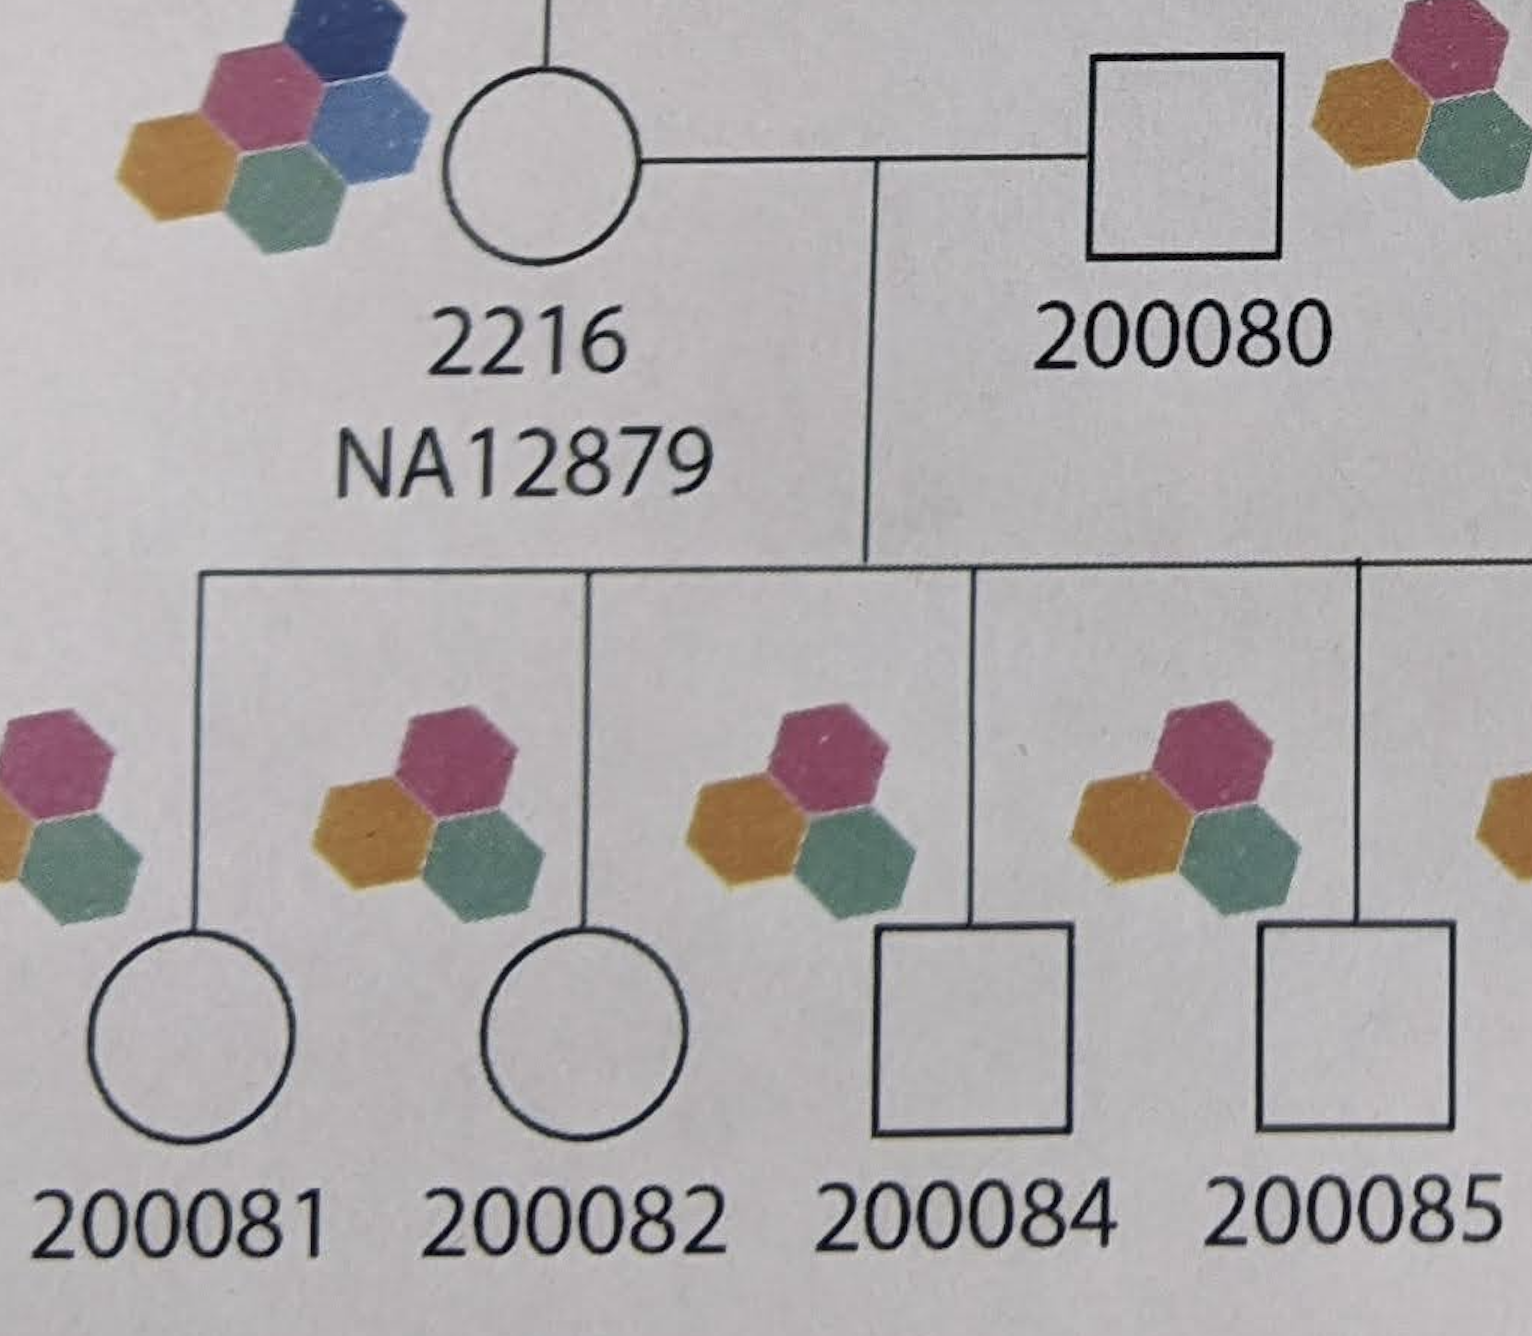

In [21]:
from IPython.display import Image, display
display(Image(filename="200080_pat-12879_mat-200081_child.png", width=600)) 